```
    ____                                   __   __         
   / __ \____ _      _____  ________  ____/ /  / /_  __  __
  / /_/ / __ \ | /| / / _ \/ ___/ _ \/ __  /  / __ \/ / / /
 / ____/ /_/ / |/ |/ /  __/ /  /  __/ /_/ /  / /_/ / /_/ / 
/_/    \____/|__/|__/\___/_/   \___/\__,_/  /_.___/\__, /  
   __________  ____  __  ______     _   _______   /____/__ 
  / ____/ __ \/ __ \/ / / / __ \   / | / /  _/ | / / ____/ 
 / / __/ /_/ / / / / / / / /_/ /  /  |/ // //  |/ / __/    
/ /_/ / _, _/ /_/ / /_/ / ____/  / /|  // // /|  / /___    
\____/_/ |_|\____/\____/_/      /_/ |_/___/_/ |_/_____/
```

# Variational Auto Encoder
### Warning:
The model used in the actual analysis has the same architecture as the one shown here but has been trained on more epochs and with more data using Google-Colab

Import necessary packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/Colab\ Notebooks/variational-autoencoders/vae

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/variational-autoencoders/vae


In [2]:
from glob import glob
import numpy as np
import numpy.random as npr
import sklearn
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg as la
from keras import regularizers
from keras import backend as K
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Input,
    Flatten,
    Dense,
    Lambda,
    Reshape,
)


Define core features of the dataset

In [3]:
npr.seed(28980)

dim = 2
numpart = 30
latent_dim = 40
box_size = 10


Import the training data and add gamma labels

In [4]:
dump_dir = "../mc-sampling/good-runs/"
# read all position files in chosen directory
files = glob(dump_dir + "gamma*_10000_*_x.txt")
# sort files by gamma value
files = np.array(files)[np.argsort([f.split("_")[1] for f in files])]
gamma = np.sort([f.split("_")[1] for f in files]).astype(float)

num_gammas = files.size
arrays = [np.loadtxt(f) for f in files]

# combine data + reshape, and assign labels to different datasets
data = np.vstack(arrays)
vcs = data.reshape((-1, numpart, dim)) / (box_size * np.sqrt(dim))
labels = np.hstack([[i] * len(a) for i, a in enumerate(arrays)])


### Manipulate data
Sort points by distance from origin

In [5]:
sort_idx = np.argsort(vcs[:, :, 0] ** 2 + vcs[:, :, 1] ** 2)
sorted_vcs = np.array(
    [sample[sort_idx[i]] for i, sample in enumerate(vcs)]
)


Compute distance matrix for each configuration

In [6]:
dm = np.array([squareform(pdist(sample)) for sample in sorted_vcs])


Split in training and test set

In [7]:
train_perc = 0.8

m = sorted_vcs.shape[0]  # total number of samples
m_training = int(m * train_perc)  # samples in the training set
m_test = m - m_training  # samples in the test set

while True:
    permutation = np.random.permutation(m)

    sorted_vcs = sorted_vcs[permutation]
    labels = labels[permutation]
    dm = dm[permutation]

    trainset_conf = sorted_vcs[:m_training]
    testset_conf = sorted_vcs[m_training:]

    trainset_mat = dm[:m_training]
    testset_mat = dm[m_training:]

    counts = [
        np.count_nonzero(labels[:m_training] == i)
        for i in range(num_gammas)
    ]

    # if each label is represented by at least half of
    # training set size / number of files
    # we're good and we can stop permutating
    if all(c > int(m_training / (2 * num_gammas)) for c in counts):
        break

print("Samples in training set: ", trainset_conf.shape[0])
print("Samples in test set: ", testset_conf.shape[0])


Samples in training set:  32000
Samples in test set:  8000


## Variational Auto Encoder
### Sampling Class

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [9]:
encoder_inputs = keras.Input(shape=(numpart, numpart, 1))
x = Conv2D(60, 3, padding="same", activation="relu")(encoder_inputs)
x = Conv2D(50, 3, padding="same", activation="relu")(x)
conv_shape = K.int_shape(x)  # Shape of conv to be provided to decoder
x = Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(
    encoder_inputs, [z_mean, z_log_var, z], name="encoder"
)
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 60)   600         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 50)   27050       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 45000)        0           ['conv2d_1[0][0]']               
                                                                                            

### Decoder

In [10]:
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
x = Dense(
    conv_shape[1] * conv_shape[2] * conv_shape[3], activation="relu"
)(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(50, 3, padding="same", activation="relu")(x)
x = Conv2DTranspose(60, 3, padding="same", activation="relu")(x)
decoder_outputs = Conv2DTranspose(
    1, 3, padding="same", activation="sigmoid", name="decoder_output"
)(x)

decoder = keras.Model(decoder_input, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 40)]              0         
                                                                 
 dense (Dense)               (None, 45000)             1845000   
                                                                 
 reshape (Reshape)           (None, 30, 30, 50)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 50)       22550     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 30, 30, 60)       27060     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 30, 30, 1)        541 

### VAE Class

In [11]:
reg_lambda = 0.00035


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Extract dimensions excluding the first 'None' dimension
            size = reconstruction.shape[1:]

            # Reshape data to match decoder output shape
            data = tf.expand_dims(data, axis=-1)

            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train VAE

In [24]:
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)  # lower learning rate
fit = vae.fit(trainset_mat, epochs=10, batch_size=128, verbose=2)

Epoch 1/10
250/250 - 14s - loss: 0.0112 - reconstruction_loss: 0.0111 - kl_loss: 0.4787 - 14s/epoch - 55ms/step
Epoch 2/10
250/250 - 6s - loss: 0.0063 - reconstruction_loss: 0.0058 - kl_loss: 1.2058 - 6s/epoch - 25ms/step
Epoch 3/10
250/250 - 7s - loss: 0.0045 - reconstruction_loss: 0.0040 - kl_loss: 1.6043 - 7s/epoch - 27ms/step
Epoch 4/10
250/250 - 6s - loss: 0.0038 - reconstruction_loss: 0.0032 - kl_loss: 1.8012 - 6s/epoch - 24ms/step
Epoch 5/10
250/250 - 6s - loss: 0.0032 - reconstruction_loss: 0.0025 - kl_loss: 1.9524 - 6s/epoch - 26ms/step
Epoch 6/10
250/250 - 6s - loss: 0.0027 - reconstruction_loss: 0.0020 - kl_loss: 2.0447 - 6s/epoch - 22ms/step
Epoch 7/10
250/250 - 6s - loss: 0.0025 - reconstruction_loss: 0.0017 - kl_loss: 2.0831 - 6s/epoch - 23ms/step
Epoch 8/10
250/250 - 6s - loss: 0.0023 - reconstruction_loss: 0.0016 - kl_loss: 2.0982 - 6s/epoch - 22ms/step
Epoch 9/10
250/250 - 6s - loss: 0.0022 - reconstruction_loss: 0.0014 - kl_loss: 2.1061 - 6s/epoch - 22ms/step
Epoch 10

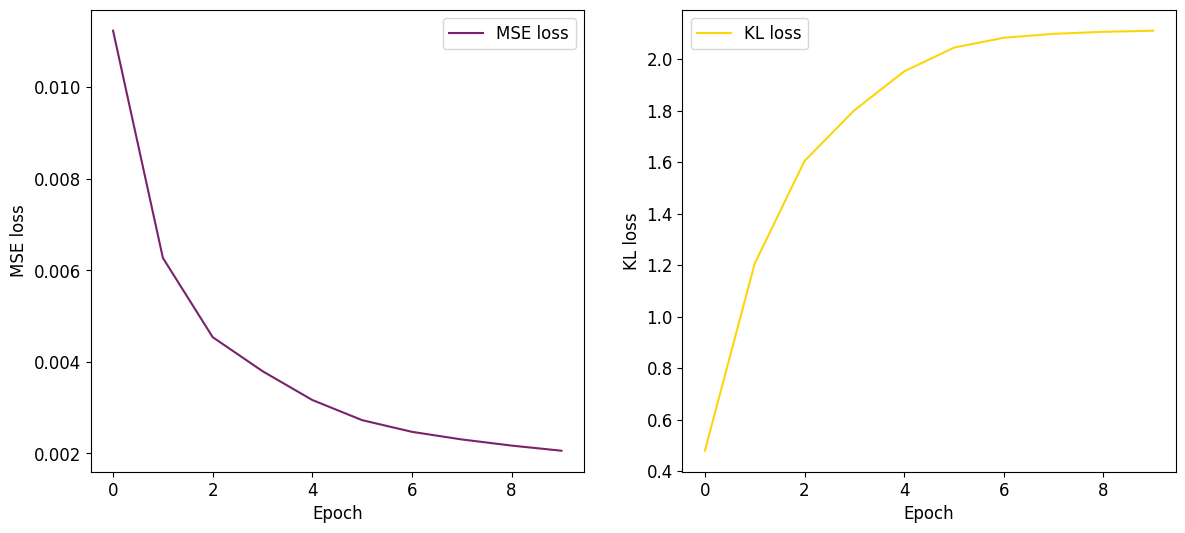

In [25]:
plt.rcParams["font.size"] = 12
fig, AX = plt.subplots(1, 2, figsize=(14, 6.0))
ax = AX[0]
ax.plot(fit.history["loss"], label="MSE loss", c="#78226B")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
ax.legend()
ax = AX[1]
ax.plot(fit.history["kl_loss"], label="KL loss", c="#FDD50B")
ax.set_xlabel("Epoch")
ax.set_ylabel("KL loss")
ax.legend()


### Save model for future use

In [26]:
"""tf.keras.models.save_model(vae.encoder, "saved_model/encoder")
tf.keras.models.save_model(vae.decoder, "saved_model/decoder")"""

'tf.keras.models.save_model(vae.encoder, "saved_model/encoder")\ntf.keras.models.save_model(vae.decoder, "saved_model/decoder")'

## Test Results

In [12]:
encoder = keras.models.load_model("./saved-models/encoder")
decoder = keras.models.load_model("./saved-models/decoder")

vae = VAE(encoder, decoder)

### Encoding and latent dimension
Encode the test set

In [13]:
encoded_test = np.array(vae.encoder.predict(testset_mat))

print(encoded_test.shape)


250/250 [==============================] - 11s 41ms/step
(3, 8000, 40)


Check clustering in latent space

In [14]:
from sklearn.decomposition import PCA


def label_vis(encoded_data, labels):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(encoded_data[0, :, :])
    variance_ratio = pca.explained_variance_ratio_
    print(variance_ratio)

    # plot
    plt.figure(figsize=(7, 7))
    plt.scatter(
        transformed_data[:, 0], transformed_data[:, 1], c=labels, alpha=0.7
    )
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

[0.04524944 0.04029258]


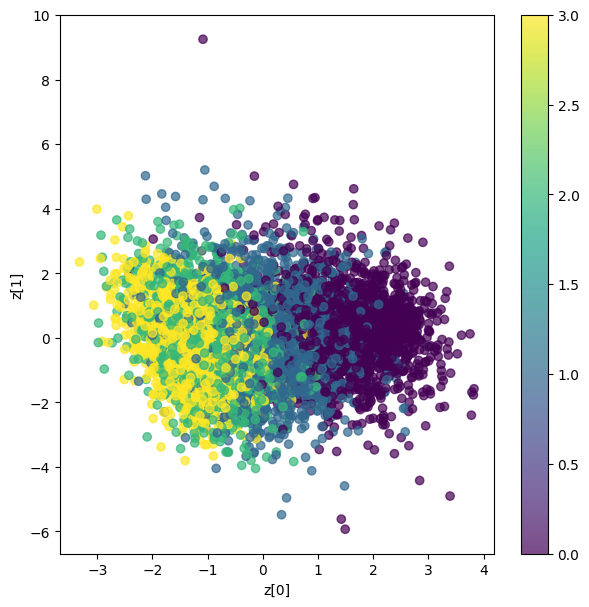

In [25]:
test_labels = labels[m_training:]
label_vis(encoded_test, test_labels)


### Decoding
Decode test set and compare to the original

In [15]:
decoded_test = np.array(decoder.predict(encoded_test[2, :, :])).reshape(
    -1, numpart, numpart
)

print(decoded_test.shape)

250/250 [==============================] - 20s 81ms/step
(8000, 30, 30)


In [28]:
def print_matrices(mat1, mat2, ind):
    df1 = pd.DataFrame(mat1[ind])
    df2 = pd.DataFrame(mat2[ind])
    df3 = pd.DataFrame(abs(mat1[ind] - mat2[ind]))

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    sns.heatmap(df1, ax=axs[0])
    axs[0].set_title("Original Data")

    sns.heatmap(df2, ax=axs[1])
    axs[1].set_title("Reconstructed Data")

    sns.heatmap(df3, cmap="mako", ax=axs[2])
    axs[2].set_title("Difference")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

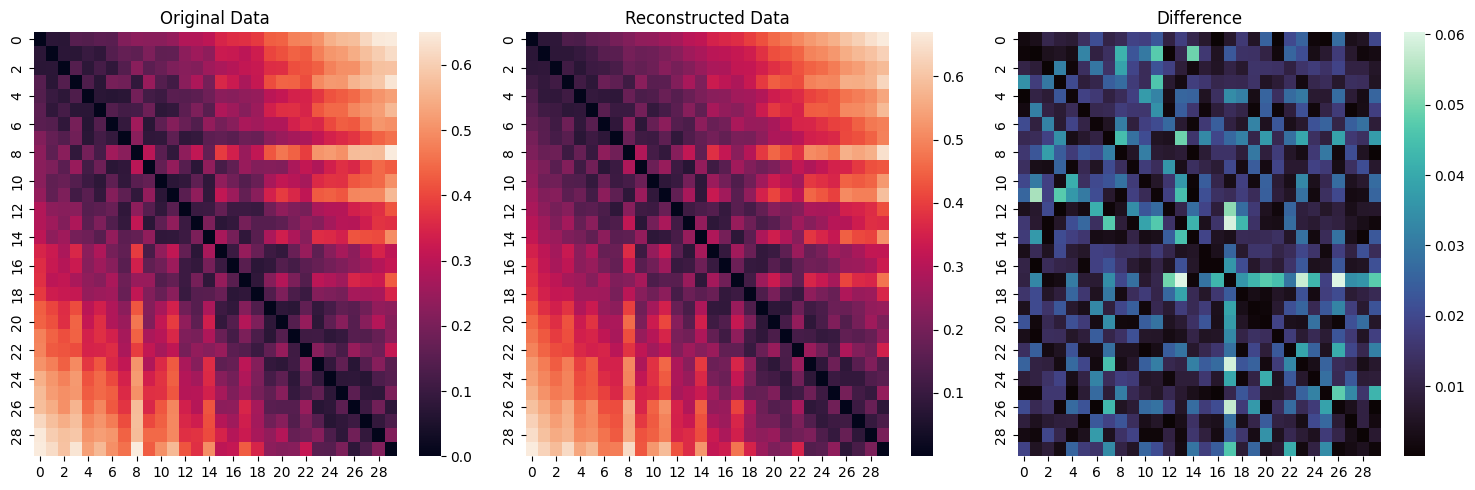

In [18]:
print_matrices(testset_mat, decoded_test, ind=42)


In [16]:
def get_mse(original, reconstruction):
    return np.sqrt(
        (np.square(original - reconstruction)).mean(axis=(1, 2))
    )


def mse_hist(original, reconstruction):
    """
    Takes two distance matrices as inputs.
    """

    if original.shape[0] != reconstruction.shape[0]:
        print("Given two arrays of different length, check or cut")
        return -1

    m = original.shape[0]

    mse = get_mse(original, reconstruction)

    plt.figure(figsize=(7, 7))
    plt.hist(mse, bins="fd", density=True)
    plt.xlabel("MSE between original and reconstructed matrix")
    plt.ylabel("Observed PDF")
    plt.show()

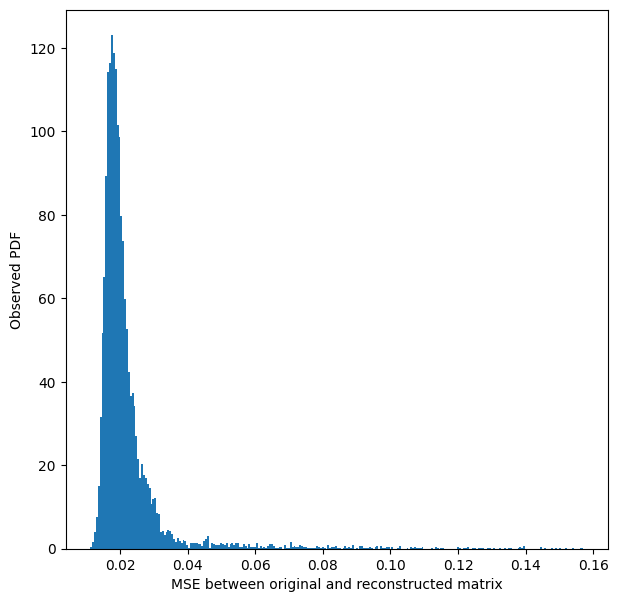

In [20]:
mse_hist(testset_mat, decoded_test)


## Reconstruct Coordinates
Extract points from distance matrix

In [17]:
def gram_to_coordinates(distance_matrix):
    # Get the number of points
    n = distance_matrix.shape[0]

    # Compute the Gram matrix
    gram_matrix = -0.5 * (distance_matrix**2)

    # Center the Gram matrix
    gram_matrix_centered = (
        gram_matrix
        - np.mean(gram_matrix, axis=0)
        - np.mean(gram_matrix, axis=1)[:, np.newaxis]
        + np.mean(gram_matrix)
    )

    # Perform eigendecomposition of the centered Gram matrix
    eigenvalues, eigenvectors = np.linalg.eigh(gram_matrix_centered)

    # Sort eigenvalues and eigenvectors in descending order
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]

    # Extract the positive square root of eigenvalues
    sqrt_eigenvalues = np.sqrt(np.maximum(eigenvalues, 0))

    # Compute the coordinates of the points in 2D space
    coordinates = eigenvectors[:, :2] * sqrt_eigenvalues[:2]

    return coordinates


Example with one configuration of the original data

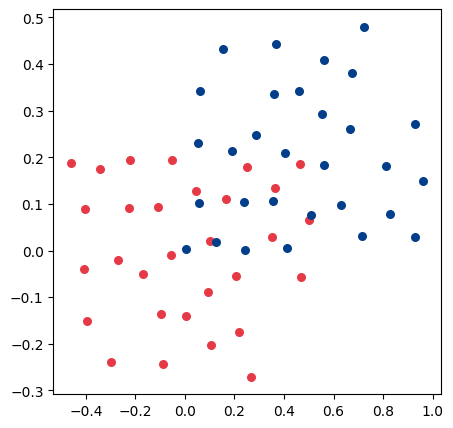

In [18]:
coordinates = gram_to_coordinates(testset_mat[1])

ind = 1
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    coordinates[:, 0] * l,
    coordinates[:, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
plt.show()


The original configuration is in blue, the reconstruction in red. This will
be the general convention throughout the notebook, unless stated otherwise.

Shift and rotate to match original data as good as possible

In [19]:
def align_points(points1, points2):
    # Center the points by subtracting their means
    centered_points1 = points1 - np.mean(points1, axis=0)
    centered_points2 = points2 - np.mean(points2, axis=0)

    # Compute the covariance matrix
    covariance_matrix = centered_points2.T @ centered_points1

    # Perform singular value decomposition (SVD)
    U, _, Vt = np.linalg.svd(covariance_matrix)

    # Calculate the optimal rotation matrix
    rotation_matrix = Vt.T @ U.T

    # Calculate the optimal translation vector
    translation_vector = np.mean(points2, axis=0) - np.mean(
        points1 @ rotation_matrix, axis=0
    )

    # Transform points1 using the estimated rotation and translation
    transformed_points = points1 @ rotation_matrix + translation_vector

    return transformed_points


Example with previous configuration

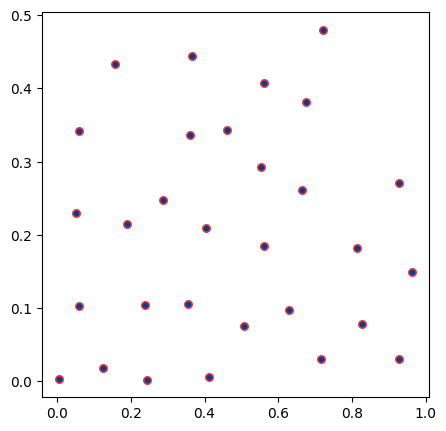

In [20]:
coordinates = align_points(coordinates, testset_conf[1])
ind = 1
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    coordinates[:, 0] * l,
    coordinates[:, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=10,
    c="#023e8a",
)
plt.show()


As we can see points are perfectly aligned

Apply to whole dataset and plot example

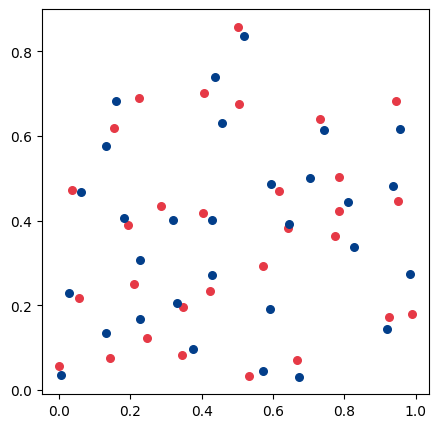

In [21]:
rec_test_dec = np.zeros((testset_conf.shape))

for i in range(0, len(rec_test_dec)):
    rec_test_dec[i] = align_points(
        gram_to_coordinates(decoded_test[i]), testset_conf[i]
    )

ind = 70
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    rec_test_dec[ind, :, 0] * l,
    rec_test_dec[ind, :, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
plt.show()

The following is part of an (unfinished) effort to algorithmically find the best translation and rotation parameters without knowledge of the original configuration. The code essentially draws a convex polygon around the particle configuration and tries to “make it sit”, minimizing the distance between the center of mass and the bottom side. Effectively, this should allow to rotate back in place the configurations that are reconstructed with an unwanted rotation.

In [26]:
def find_best_params(points):
    init_trans = np.mean(points, axis=0)
    centered_points = points - init_trans

    def sign(x):
        if x > 0:
            return 1
        if x < 0:
            return -1
        return 0

    # order by distance form the center
    centered_points = np.array(
        sorted(
            centered_points,
            key=lambda x: x[0] ** 2 + x[1] ** 2,
            reverse=True,
        )
    )
    # take 3 furthest
    selected_points = [centered_points[i] for i in range(3)]

    selected_points = sorted(
        selected_points, key=lambda x: np.arctan2(x[1], x[0])
    )

    # going in decreasing distance order, check if each successive point is
    ##  within the poligon with the currently selected point as vertices
    for p in centered_points[3:]:
        inside = True
        for j in range(len(selected_points)):
            p1 = selected_points[j]
            p2 = selected_points[j - 1]

            norm = np.array([p1[1] - p2[1], p2[0] - p1[0]])
            centr = (p1 + p2) / 2

            if sign(np.dot(p - centr, norm)) > 0:
                inside = False
                break

        if not inside:
            # if not in poligon, select the point
            selected_points.append(p)
            selected_points = sorted(
                selected_points, key=lambda x: np.arctan2(x[1], x[0])
            )

    # find the polygon segment that is closer to the center
    # selected_points = sorted(selected_points, key=lambda x: np.arctan2(x[1], x[0]))
    dists = [0 for i in range(len(selected_points))]
    for i in range(len(selected_points)):
        p1 = selected_points[i]
        p2 = selected_points[i - 1]

        norm = np.array([p1[1] - p2[1], p2[0] - p1[0]])
        # print((norm[0]**2+norm[1]**2)**0.5, p1, p2, selected_points)
        norm /= (norm[0] ** 2 + norm[1] ** 2) ** 0.5
        centr = (p1 + p2) / 2
        dists[i] = np.abs(np.dot(centr, norm))

    c_ind = dists.index(min(dists))  # index of closest segment

    # turn points so that segment faces down
    p1 = selected_points[c_ind]
    p2 = selected_points[c_ind - 1]
    norm = np.array([p1[1] - p2[1], p2[0] - p1[0]])

    ##plt.scatter([i[0] for i in centered_points],[i[1] for i in centered_points], c="blue")
    ##plt.scatter([i[0] for i in selected_points],[i[1] for i in selected_points], c="#00ff00", s=10)

    theta = np.pi * 3 / 2 - np.arctan2(norm[1], norm[0])
    rot_mat = np.array(
        [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
    )

    centered_points = centered_points @ rot_mat
    selected_points = np.array(selected_points) @ rot_mat
    # shift in place
    selected_points -= centered_points.min(axis=0)
    centered_points -= centered_points.min(axis=0)
    return centered_points, selected_points

# Testing VAE Capabilities

### Part 1 - Energy distribution

In [27]:
def potential(x, gamma):
    n = len(x)
    pot = 0.0
    for i in range(n - 1):
        pot += gamma * x[i, -1]
        for j in range(i + 1, n):
            r2 = np.sum((x[i, :] - x[j, :]) ** 2)
            if r2 < 1.0:
                continue
            if r2 < 9.0:  # r_cut = 3 sigma
                sr6 = 1.0 / r2**3
                pot += 4 * (sr6**2 - sr6)
    pot += gamma * x[-1, -1]

    return pot


In [28]:
scale_factor = box_size * np.sqrt(dim)
ori_pots = [
    potential(sample, gamma[labels[idx]])
    for idx, sample in enumerate(testset_conf * scale_factor)
]
rec_pots = [
    potential(sample, gamma[labels[idx]])
    for idx, sample in enumerate(rec_test_dec * scale_factor)
]


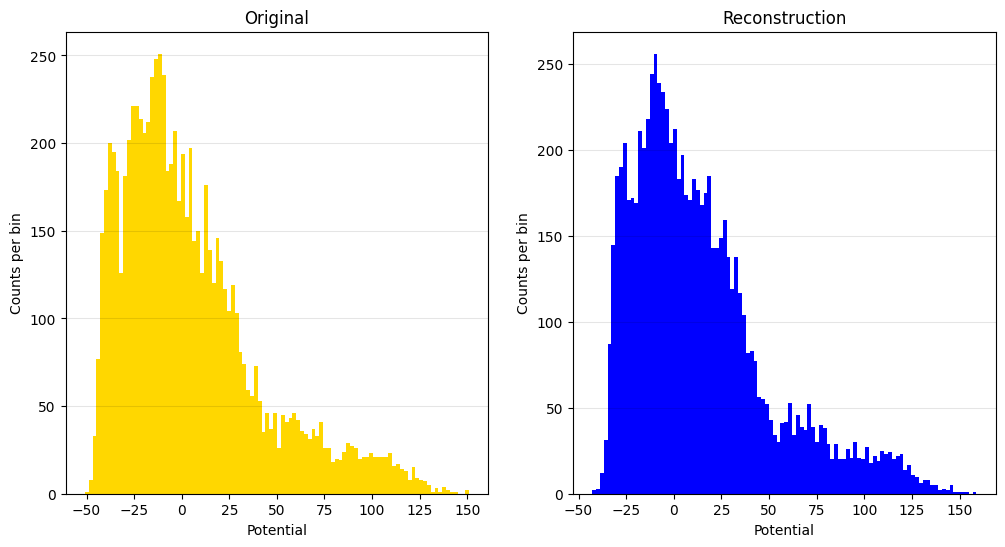

In [29]:
nbins = 100

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ori_n, ori_bins, _ = ax[0].hist(ori_pots, bins=nbins, facecolor="gold")
ax[0].set_title("Original")
rec_n, rec_bins, _ = ax[1].hist(rec_pots, bins=nbins, facecolor="blue")
ax[1].set_title("Reconstruction")


for i in range(2):
    ax[i].set_xlabel("Potential")
    ax[i].set_ylabel("Counts per bin")
    ax[i].grid(axis="y", alpha=0.1, color="black")

Now we will compare the two distributions by calculating their Jensen–Shannon divergence, a symmetrized version of the Kullback–Leibler divergence, defined as

$$
    \operatorname{JSD}(P \:\Vert\: Q) = \frac{1}{2} D(P \:\Vert\: M)
        + \frac{1}{2} D(Q \:\Vert\: M),
$$

where $D$ is the usual Kullback–Leibler and $M = (P + Q) / 2$. $P$ and $Q$ must be normalized probability density functions: in our case they will be the bin heights of the previous histograms.

In [30]:
from scipy.spatial.distance import jensenshannon


def jsd(p, q):
    """
    Returns the Jensen-Shannon divergence of two datasets.
    """

    p = np.asarray(p, dtype="float")
    q = np.asarray(q, dtype="float")

    # get optimal bin edges ("fd" tries to minimize the integral
    # of the squared difference between the histogram and
    # the theoretical pdf)
    rng_pq = (min(np.min(p), np.min(q)), max(np.max(p), np.max(q)))
    dxp = np.histogram_bin_edges(p, bins="fd", range=rng_pq)
    dxq = np.histogram_bin_edges(q, bins="fd", range=rng_pq)

    nb = max(len(dxp), len(dxq))
    dx = min(np.diff(dxp)[0], np.diff(dxq)[0])

    p, _ = np.histogram(p, bins=nb, range=rng_pq)
    q, _ = np.histogram(q, bins=nb, range=rng_pq)

    # jensenshannon from scipy normalizes p, q automatically
    return jensenshannon(p, q)

In [31]:
jsd(ori_pots, rec_pots)


0.1849060356748982

### Part 2 - Generating from an untrained gamma
Import a dataset with a gamma not seen in training

In [32]:
untr_file = glob("../mc-sampling/good-runs/impostor_gamma_3.txt")[0]
untr_gamma = 3

untr_data = np.loadtxt(untr_file).reshape((-1, numpart, dim)) / (
    box_size * np.sqrt(dim)
)
m_untr = len(untr_data)
untr_labels = np.asarray([untr_gamma] * m_untr)

sort_idx = np.argsort(untr_data[:, :, 0] ** 2 + untr_data[:, :, 1] ** 2)
untr_data = np.asarray(
    [sample[sort_idx[i]] for i, sample in enumerate(untr_data)],
    dtype="float",
)

untr_dm = np.asarray(
    [squareform(pdist(sample)) for sample in untr_data], dtype="float"
)

encoded_untr = np.asarray(vae.encoder.predict(untr_dm), dtype="float")
print(encoded_untr.shape)

decoded_untr = np.asarray(
    decoder.predict(encoded_untr[2, :, :]), dtype="float"
).reshape(-1, numpart, numpart)
print(decoded_untr.shape)

250/250 [==============================] - 11s 44ms/step
(3, 8000, 40)
250/250 [==============================] - 19s 76ms/step
(8000, 30, 30)


In [22]:
def untr_label_vis(encoded_data, encoded_untr_data, labels, n_comp):
    pca = PCA(n_components=n_comp)
    transformed_data = pca.fit_transform(encoded_data[0, :, :])
    variance_ratio = pca.explained_variance_ratio_
    print(variance_ratio)

    untr_transformed_data = pca.transform(
        encoded_untr_data[0, :, :]
    )

    if n_comp == 2:
        plt.figure(figsize=(7, 7))
        plt.scatter(
            transformed_data[:, 0],
            transformed_data[:, 1],
            c=labels,
            alpha=0.5,
        )
        plt.scatter(
            untr_transformed_data[:, 0],
            untr_transformed_data[:, 1],
            c="red",
            alpha=0.8,
        )
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.show()
    elif n_comp == 3:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(projection="3d")
        ax.scatter(
            transformed_data[:, 0],
            transformed_data[:, 1],
            transformed_data[:, 2],
            c=labels,
            alpha=0.5,
        )
        ax.scatter(
            untr_transformed_data[:, 0],
            untr_transformed_data[:, 1],
            untr_transformed_data[:, 2],
            c="red",
            alpha=0.5,
        )
        ax.set_xlabel("z[0]")
        ax.set_ylabel("z[1]")
        ax.set_zlabel("z[2]")
        plt.show()

[0.04529458 0.04060583]


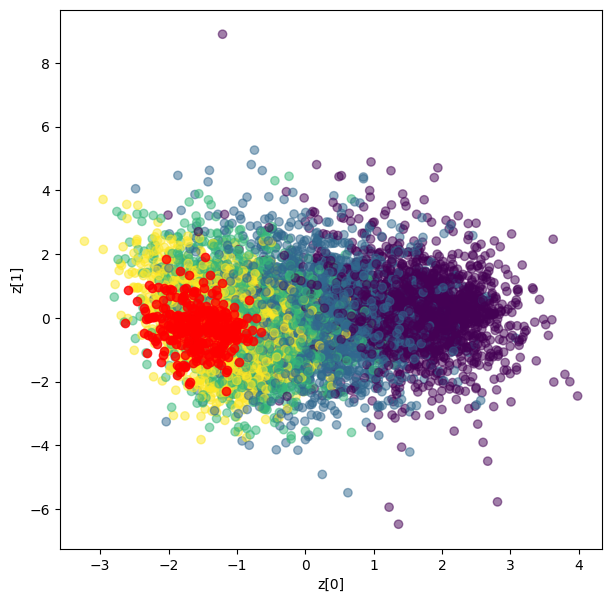

In [34]:
untr_label_vis(
    encoded_test[:, :m_untr, :],
    encoded_untr[:, :300, :],
    test_labels[:m_untr],
    2,
)

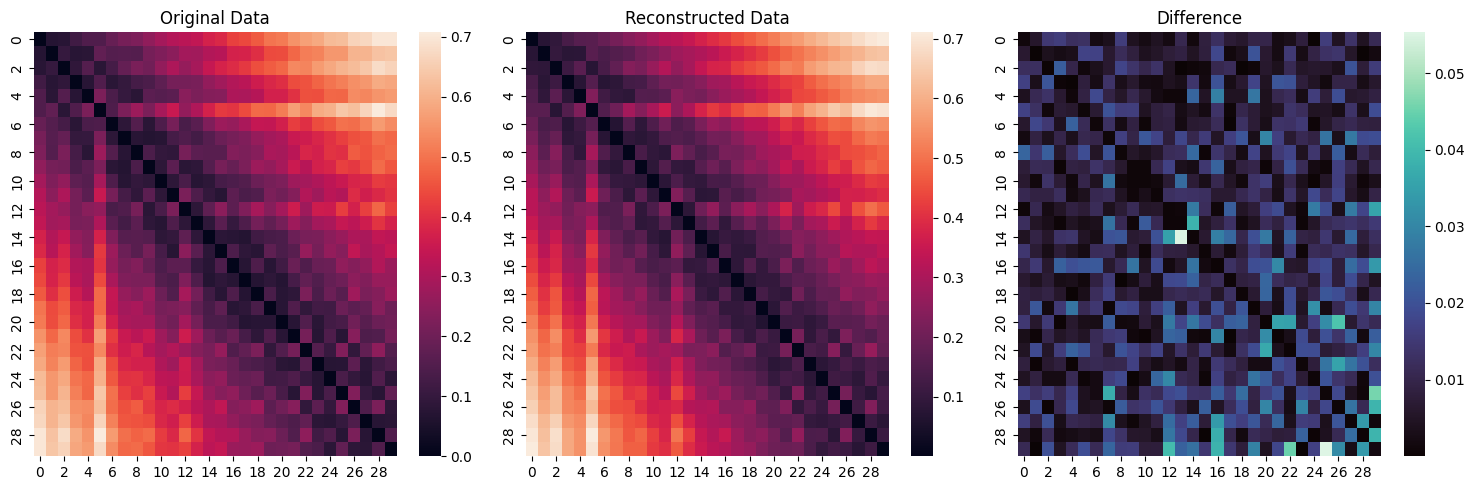

In [35]:
print_matrices(untr_dm, decoded_untr, ind=1)


Performance is similar to the other data

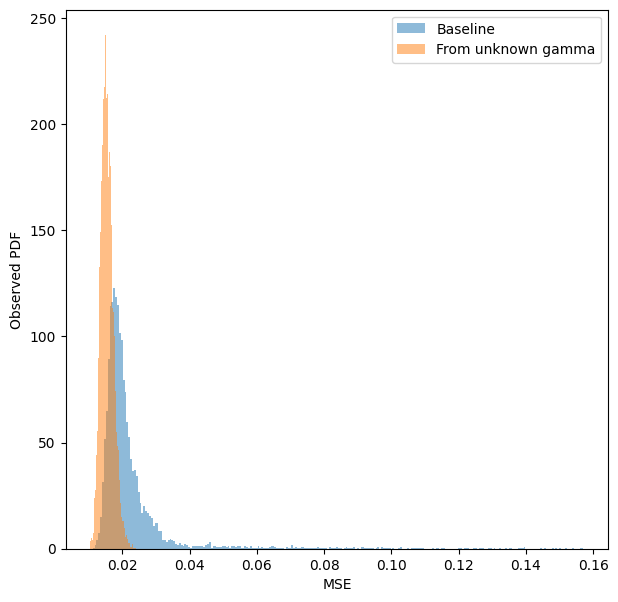

In [36]:
baseline_mse = get_mse(testset_mat, decoded_test)
untr_mse = get_mse(untr_dm, decoded_untr)

plt.figure(figsize=(7, 7))
plt.hist(
    baseline_mse, bins="fd", density=True, alpha=0.5, label="Baseline"
)
plt.hist(
    untr_mse,
    bins="fd",
    density=True,
    alpha=0.5,
    label="From unknown gamma",
)
plt.legend()
plt.xlabel("MSE")
plt.ylabel("Observed PDF")
plt.show()

The peak of the MSE distribution is close to the one we got previously with the “seen-during-training” configurations.

### Part 3 - Corrupted data
In this section we will purposefully move some points in the configurations by a random amounts an check wether the VAE will be able to reconstruct the original or an otherwise valid configuration

In [37]:
def corrupt_func(config_points, num_points_to_move, step_size):
    num_points = config_points.shape[0]
    indices_to_move = npr.choice(
        num_points, num_points_to_move, replace=False
    )
    displacements = npr.uniform(
        -step_size, step_size, (num_points_to_move, config_points.shape[1])
    )
    new_points = np.copy(config_points)
    new_points[indices_to_move] += displacements

    return new_points

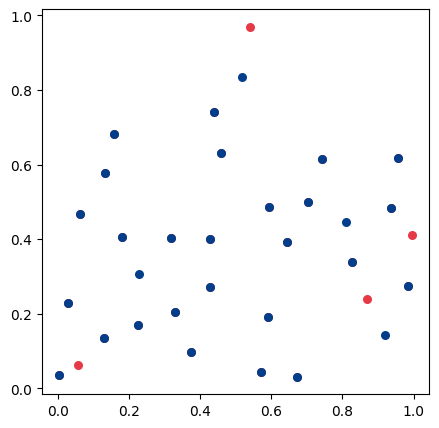

In [38]:
corr_conf = np.copy(testset_conf)

for i in range(0, len(corr_conf)):
    corr_conf[i] = corrupt_func(corr_conf[i], 4, 0.2)

ind = 70
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    corr_conf[ind, :, 0] * l,
    corr_conf[ind, :, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
plt.show()

In [39]:
corr_dm = np.array([squareform(pdist(sample)) for sample in corr_conf])

encoded_corr = np.array(vae.encoder.predict(corr_dm))
decoded_corr = np.array(decoder.predict(encoded_corr[2, :, :])).reshape(
    -1, numpart, numpart
)

250/250 [==============================] - 27s 107ms/step


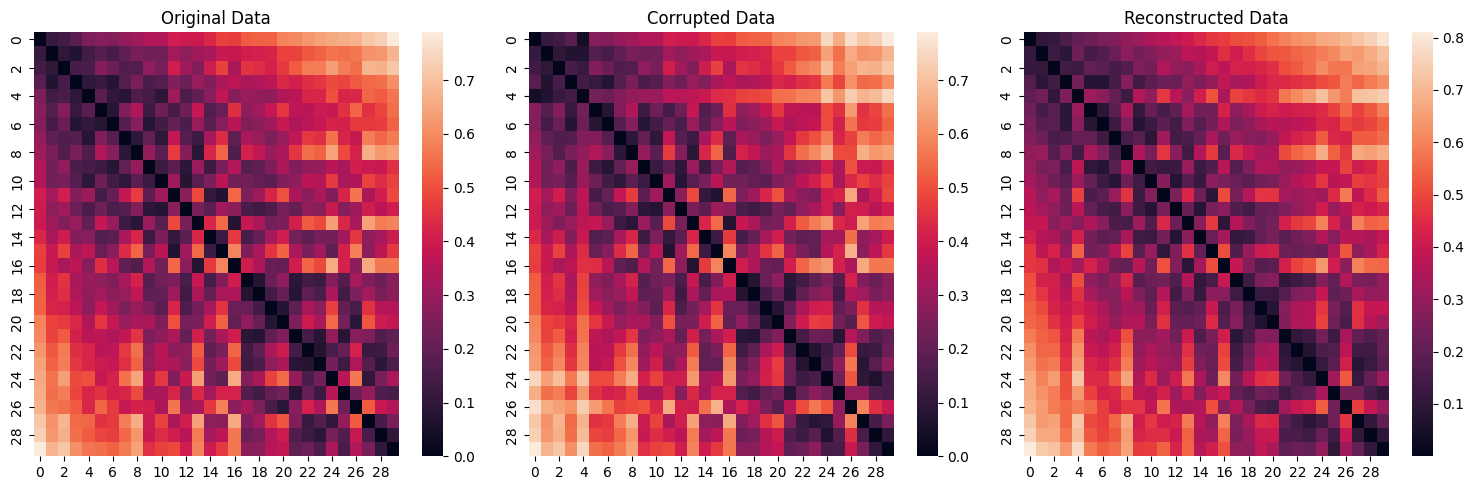

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(pd.DataFrame(testset_mat[ind]), ax=axs[0])
axs[0].set_title("Original Data")

sns.heatmap(pd.DataFrame(corr_dm[ind]), ax=axs[1])
axs[1].set_title("Corrupted Data")

sns.heatmap(pd.DataFrame(decoded_corr[ind]), ax=axs[2])
axs[2].set_title("Reconstructed Data")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

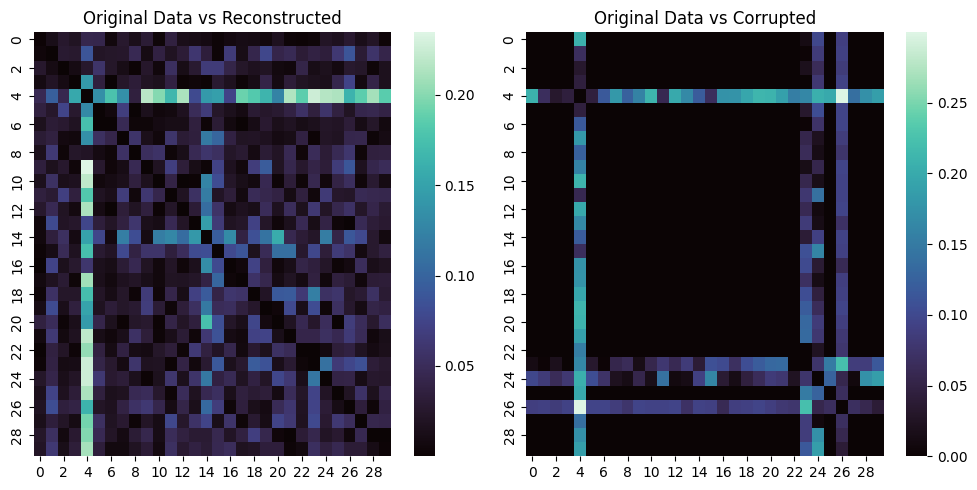

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(
    pd.DataFrame(abs(decoded_corr[ind] - testset_mat[ind])),
    ax=axs[0],
    cmap="mako",
)
axs[0].set_title("Original Data vs Reconstructed")

sns.heatmap(
    pd.DataFrame(abs(corr_dm[ind] - testset_mat[ind])),
    ax=axs[1],
    cmap="mako",
)
axs[1].set_title("Original Data vs Corrupted")


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

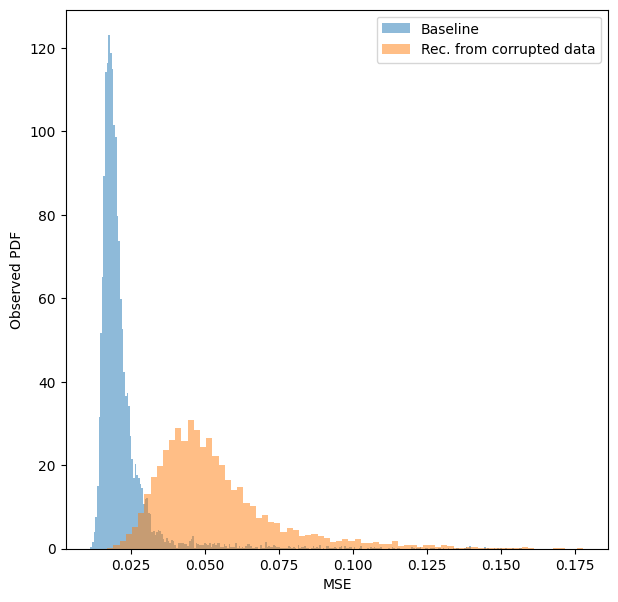

In [42]:
plt.figure(figsize=(7, 7))
plt.hist(
    baseline_mse, bins="fd", density=True, alpha=0.5, label="Baseline"
)
plt.hist(
    get_mse(corr_dm, decoded_corr),
    bins="fd",
    density=True,
    alpha=0.5,
    label="Rec. from corrupted data",
)
plt.legend()
plt.xlabel("MSE")
plt.ylabel("Observed PDF")
plt.show()

It seems like it is modifying the whole distance matrix to try to accomodate the "faulty" points. Let's see how does it translate to configurations

In [43]:
rec_corr = np.zeros((corr_conf.shape))

for i in range(0, len(decoded_corr)):
    rec_corr[i] = align_points(
        gram_to_coordinates(decoded_corr[i]), corr_conf[i]
    )

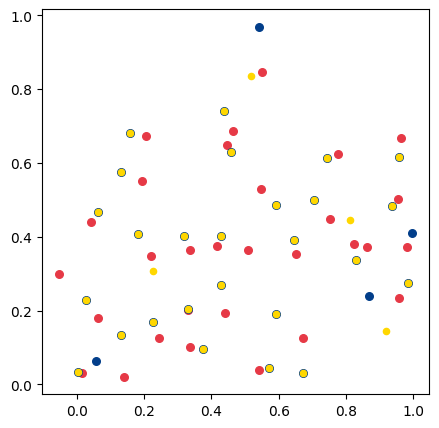

In [44]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    rec_corr[ind, :, 0] * l,
    rec_corr[ind, :, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    corr_conf[ind, :, 0] * l,
    corr_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=20,
    c="gold",
)
plt.show()


Original data is in yellow, corrupted data in blue (equal to the original except for 4 points) while the red data are the reconstructed

### Part 4 - Missing data
We'll explore what happens when data is missing from the distance matrix

In [45]:
def fixing_matrix(index, n_hidd, ind, test_dm):
    missing_dm = np.copy(test_dm[index, :, :])

    if n_hidd == numpart:
        ind = 0

    missing_dm[ind : ind + n_hidd, ind : ind + n_hidd] = np.zeros(
        (n_hidd, n_hidd)
    )

    missing_dm = np.reshape(missing_dm, (1, numpart, numpart, 1))
    missing_dm.shape

    enc_miss = encoder.predict(missing_dm)
    rec_miss = decoder.predict(enc_miss[2])

    missing_dm = missing_dm.reshape(numpart, numpart)
    rec_miss = rec_miss.reshape(numpart, numpart)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    sns.heatmap(pd.DataFrame(missing_dm), ax=axs[0])
    axs[0].set_title("Missing DM Heatmap")

    sns.heatmap(pd.DataFrame(rec_miss), ax=axs[1])
    axs[1].set_title("Rec Miss Heatmap")

    sns.heatmap(pd.DataFrame(test_dm[index, :, :]), ax=axs[2])
    axs[2].set_title("Test DM Heatmap")

    df3 = abs((rec_miss - test_dm[index, :, :]))
    np.fill_diagonal(df3, 0)
    df3 = pd.DataFrame(df3)
    sns.heatmap(data=df3, cmap="mako", ax=axs[3])
    axs[3].set_title("differences DM Heatmap")

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 151ms/step


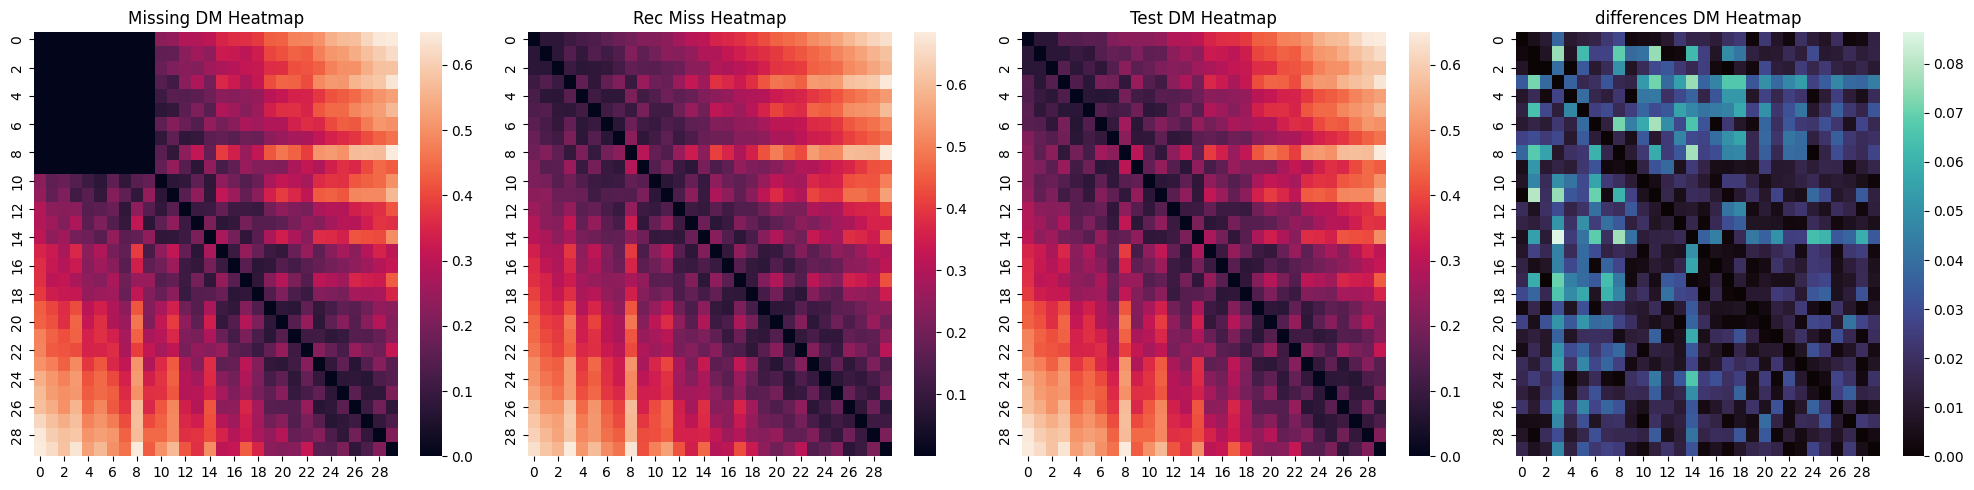

In [46]:
fixing_matrix(42, 10, 0, testset_mat)


1/1 [==============================] - 0s 19ms/step


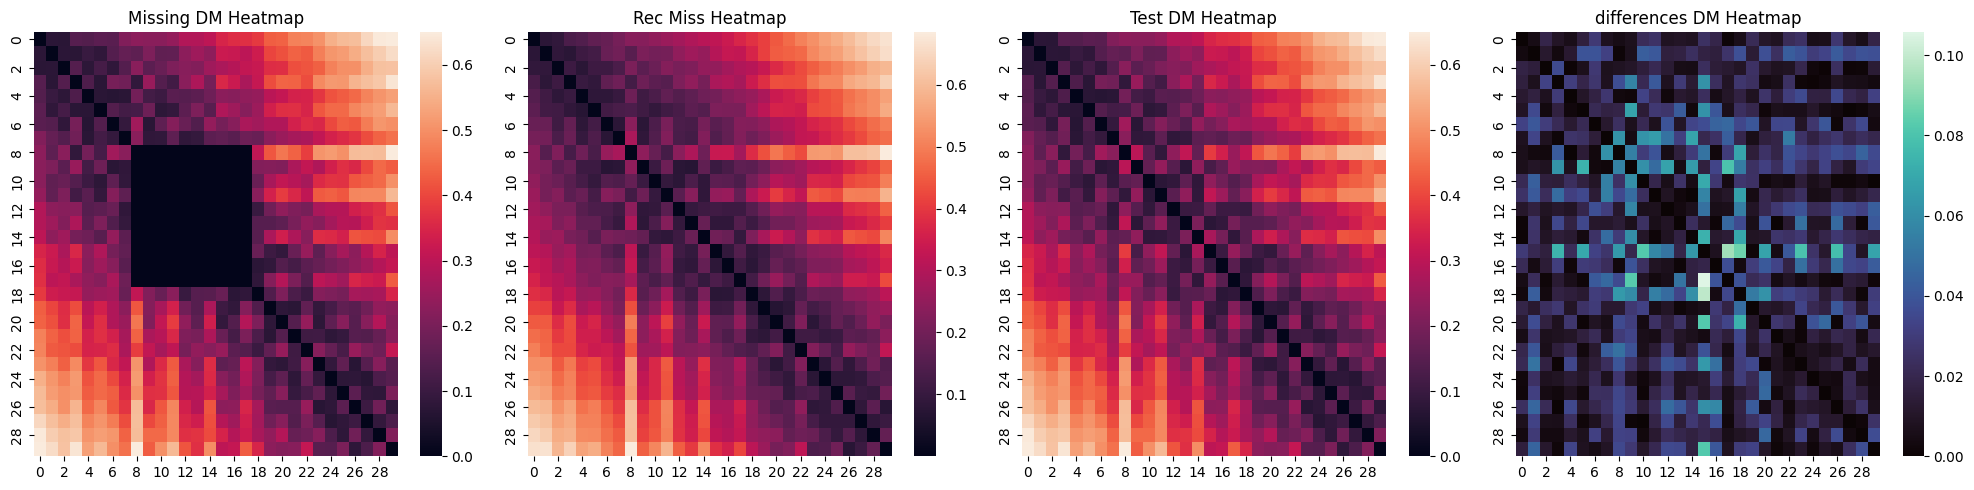

In [47]:
fixing_matrix(42, 10, 8, testset_mat)


1/1 [==============================] - 0s 19ms/step


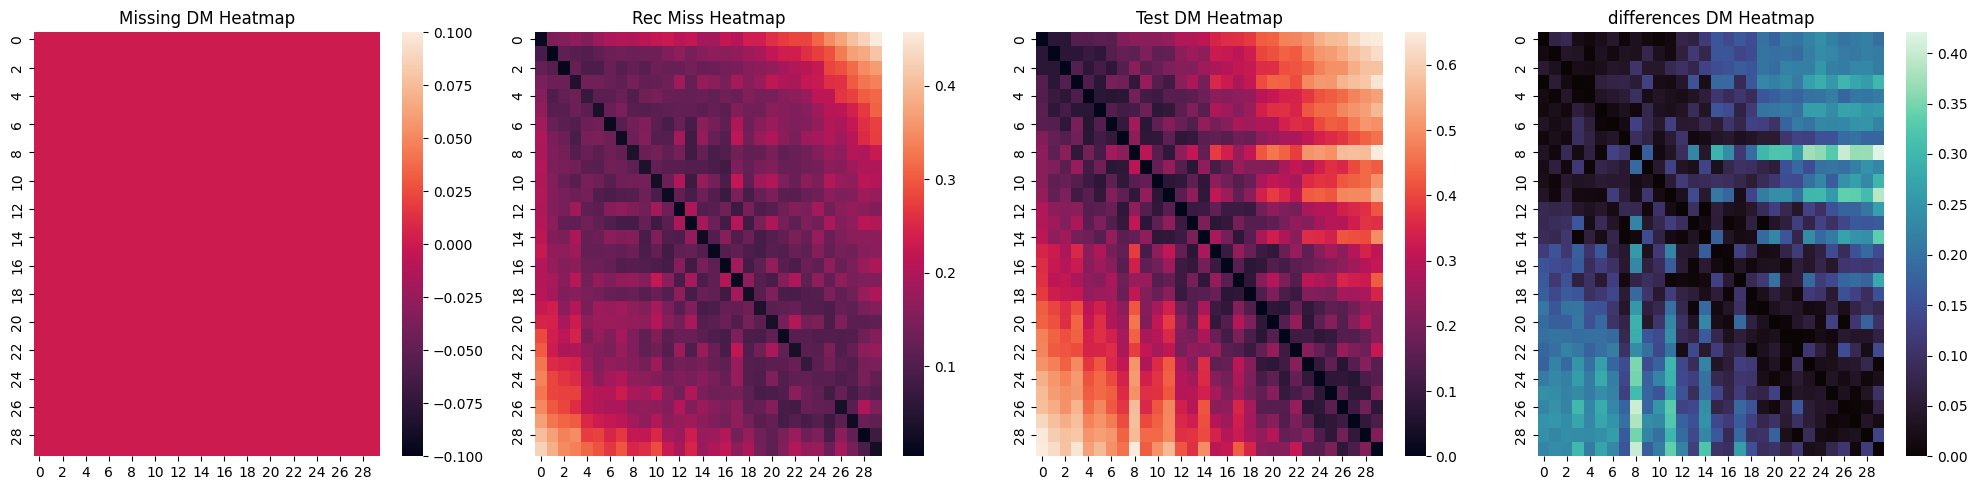

In [48]:
fixing_matrix(42, 30, 0, testset_mat)


### Part 5 - Detecting a different potential
We have generated some configurations with a different potential, a
“modified” Lennard-Jones summed to the gravitational one weighted by the $\gamma$ parameter as before:

$$
    U'_i = 4 \sum_{j \neq i} \biggl(\frac{1}{r_{ij}^2} - \frac{1}{r_{ij}^2}\biggr) + \gamma\, y_i
$$

In [23]:
fake_file = glob("../mc-sampling/good-runs/fake_*")[0]
fake_gamma = float(fake_file.split("_")[2])
fake_data = (np.loadtxt(fake_file)).reshape((-1, numpart, dim)) / (
    box_size * np.sqrt(dim)
)
m_fake = len(fake_data)
fake_labels = np.asarray([fake_gamma] * m_fake)

sort_idx = np.argsort(fake_data[:, :, 0] ** 2 + fake_data[:, :, 1] ** 2)
fake_data = np.asarray(
    [sample[sort_idx[i]] for i, sample in enumerate(fake_data)],
    dtype="float"
)

fake_dm = np.asarray(
    [squareform(pdist(sample)) for sample in fake_data],
    dtype="float"
)

encoded_fake = np.asarray(vae.encoder.predict(fake_dm), dtype="float")
print(encoded_fake.shape)

decoded_fake = np.asarray(
    vae.decoder.predict(encoded_fake[2, :, :]), dtype="float"
).reshape(-1, numpart, numpart)
print(decoded_fake.shape)

313/313 [==============================] - 12s 38ms/step
(3, 10000, 40)
313/313 [==============================] - 26s 82ms/step
(10000, 30, 30)


[0.04529458 0.04060583]


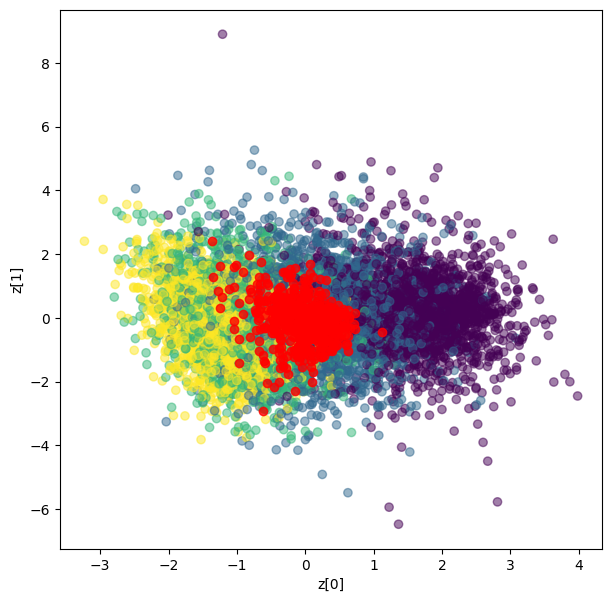

In [26]:
untr_label_vis(encoded_test, encoded_fake[:, :500, :], test_labels, 2)

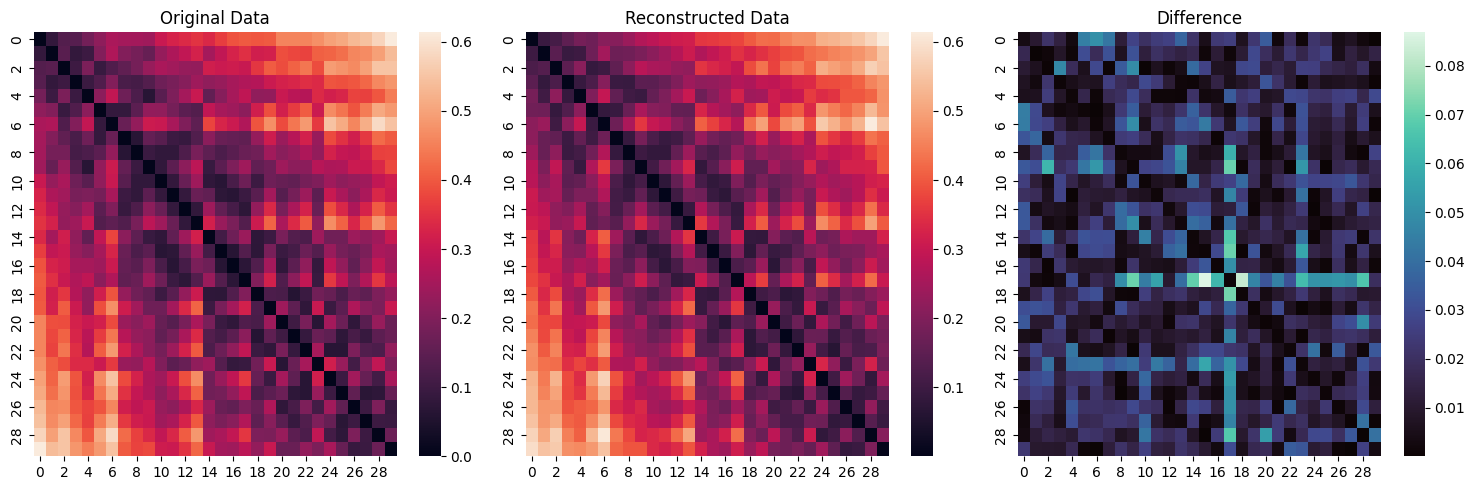

In [29]:
print_matrices(fake_dm, decoded_fake, ind=42)


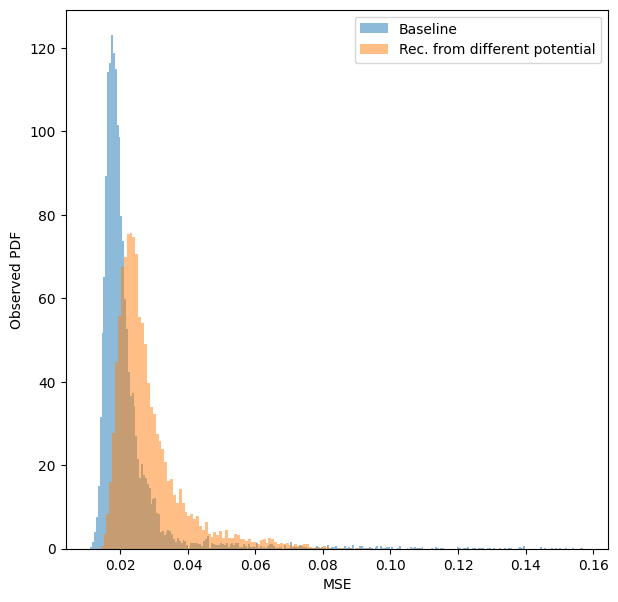

In [32]:
plt.figure(figsize=(7, 7))
plt.hist(
    baseline_mse, bins="fd", density=True, alpha=0.5, label="Baseline"
)
plt.hist(
    get_mse(fake_dm, decoded_fake),
    bins="fd",
    density=True,
    alpha=0.5,
    label="Rec. from different potential",
)
plt.legend()
plt.xlabel("MSE")
plt.ylabel("Observed PDF")
plt.show()

### Part 6 - Detecting an unphysical configuration
We will generate an obviously unphysical configuration – a purely
uniform distribution of particles inside the box – and see how the model behaves.

313/313 [==============================] - 24s 75ms/step
[0.04532137 0.04034645]


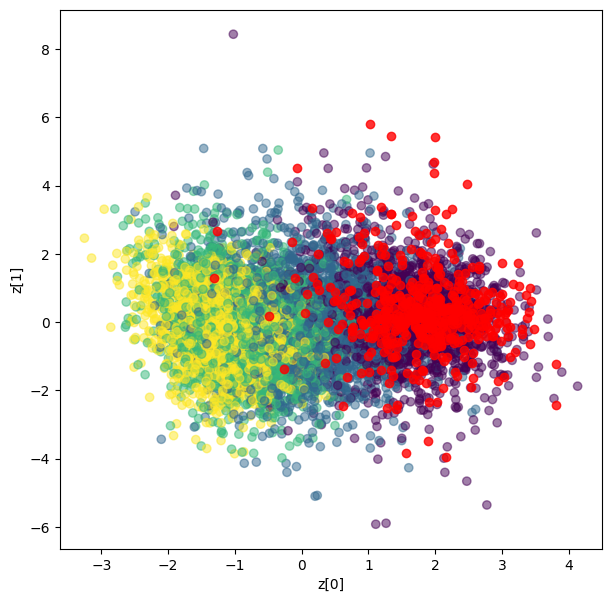

In [33]:
m_wrong = 10000
wrong_data = np.random.uniform(
    0, 1 / np.sqrt(dim), size=(m_wrong, numpart, dim)
)

sort_idx = np.argsort(wrong_data[:, :, 0] ** 2 + wrong_data[:, :, 1] ** 2)
wrong_data = np.asarray(
    [sample[sort_idx[i]] for i, sample in enumerate(wrong_data)],
    dtype="float",
)

wrong_dm = np.asarray(
    [squareform(pdist(sample)) for sample in wrong_data], dtype="float"
)

encoded_wrong = np.asarray(vae.encoder.predict(wrong_dm), dtype="float")
decoded_wrong = np.asarray(
    vae.decoder.predict(encoded_wrong[2, :, :]), dtype="float"
).reshape(-1, numpart, numpart)

untr_label_vis(encoded_test, encoded_wrong[:, :500, :], test_labels, 2)

Let’s see how the reconstruction went.

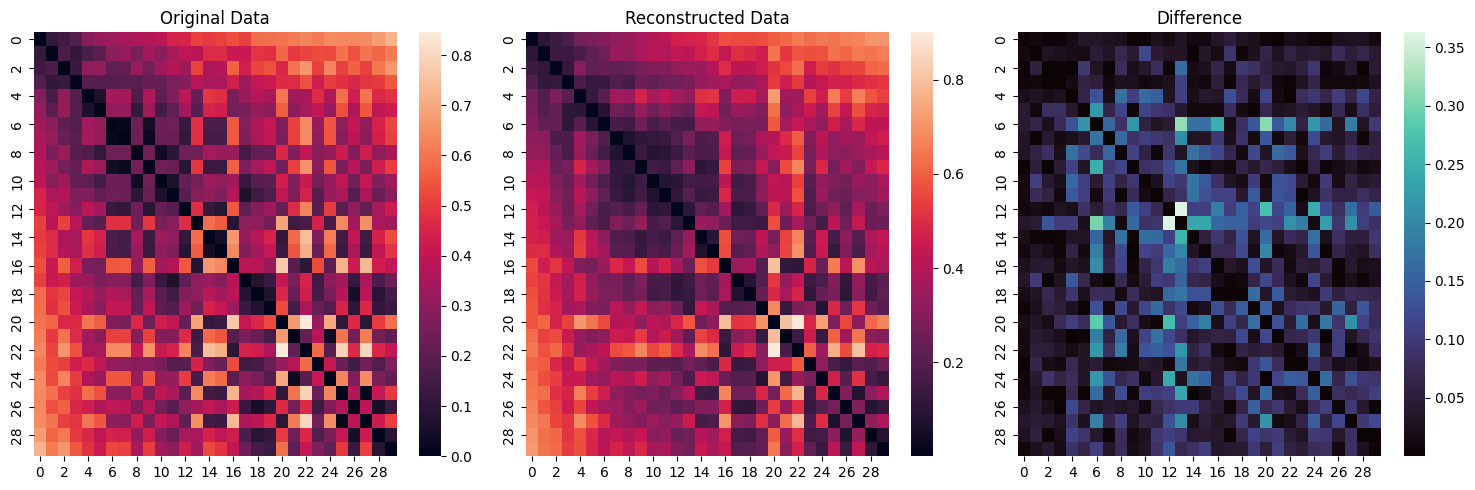

In [34]:
print_matrices(wrong_dm, decoded_wrong, ind=227)


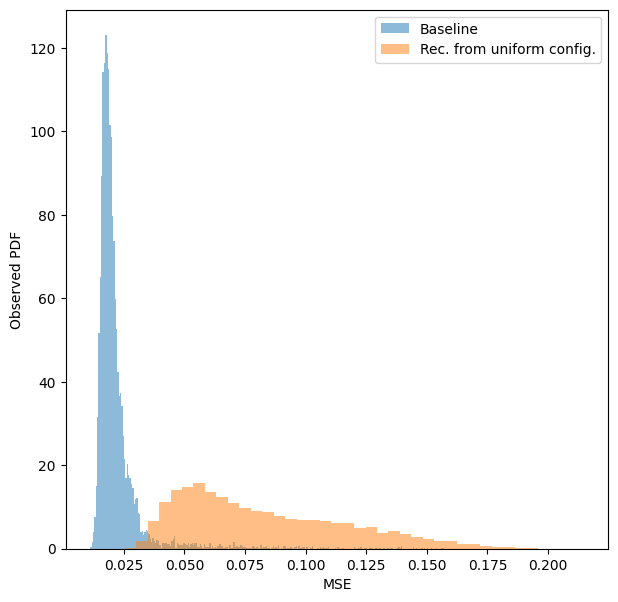

In [35]:
plt.figure(figsize=(7, 7))
plt.hist(
    baseline_mse, bins="fd", density=True, alpha=0.5, label="Baseline"
)
plt.hist(
    get_mse(wrong_dm, decoded_wrong),
    bins="fd",
    density=True,
    alpha=0.5,
    label="Rec. from uniform config.",
)
plt.legend()
plt.xlabel("MSE")
plt.ylabel("Observed PDF")
plt.show()

The difference is noticeably big.